In [1]:
from tqdm import tqdm

from MULTIANGLE_QAOA.ma_qaoa_src.Ansatz import *
import scipy as sc
from qiskit.visualization import plot_histogram


In [2]:
# Generating random graph 
n = 4
rng_seed = int(np.random.randint(0,2**31-1))
np.random.seed(rng_seed)
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
edge_list = generate_random_graph(nodes=n,weighted=True,w_min=1e-2,seed=rng_seed)

# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(edge_list)


Best solution = [0 1 0 1] cost = -2.4494


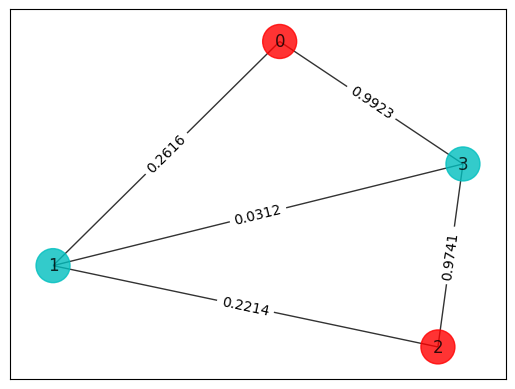

In [3]:
# Calculating optimal partition and plotting
best_cost, best_perm = qubo_min_cost_partition(nr_nodes=n,Q_mat=get_qubo(size=n,edges=edge_list))
colors = ["r" if best_perm[i] == 0 else "c" for i in range(n)]
print("\nBest solution = " + str(best_perm) + " cost = " + str(best_cost))
pos = nx.spring_layout(G)
draw_graph(G, colors, pos)


In [11]:
# Number of repetitions of (cost, mixer) in circuit
layers=2

# Defining instance of QAOA ansatz
QAOA_objective = MAQAOAansatz(n_qubits=n, n_layers=layers, w_edges=edge_list, backend="SYMQ", precision=64)

# Initial guess for parameters (beta, gamma) of circuit
np.random.seed(0)
theta_min, theta_max = -np.pi, np.pi
gamma_i = np.random.uniform(low=theta_min, high=theta_max,size=QAOA_objective.nr_cost_terms * layers).tolist()
beta_i = np.random.uniform(low=theta_min, high=theta_max,size=QAOA_objective.nr_mixer_terms * layers).tolist()
theta_i = gamma_i + beta_i


# Function to track optimization progress using tqdm
def callback(xk,*_):
    pbar.update(1)

# ------ Optimizer run ------ #

# Optimizer technique 1)
_available_methods_ = ['Nelder-Mead', 'Powell', 'COBYLA', 'trust-constr']
with tqdm(total=None, desc="Optimizing", ascii=True) as pbar:
    res = sc.optimize.minimize(fun=QAOA_objective.evaluate_circuit, x0=theta_i,method=_available_methods_[2],callback=callback, options={'disp': True, 'maxiter': 5000})

# Optimizer technique 2)
#res = sc.optimize.basinhopping(func=QAOA_objective.evaluate_circuit, x0=theta_i, niter=10, stepsize=0.75)

# Optimizer technique 3)
#_available_strategies_ = ['best1bin', 'best1exp', 'rand1exp', 'randtobest1exp', 'currenttobest1exp', 'best2exp', 'rand2exp', 'randtobest1bin', 'currenttobest1bin', 'best2bin', 'rand2bin', 'rand1bin']
#res = sc.optimize.differential_evolution(func=QAOA_objective.evaluate_circuit,bounds=[(theta_min, theta_max) for angle in theta_i], strategy=_available_strategies_[1],popsize=2, maxiter=50)

# Optimizer technique 4)
#_available_sampling_methods_ = ['simplicial', 'halton', 'sobol']
#res = sc.optimize.shgo(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], sampling_method=_available_sampling_methods_[2],callback=printx)

# Optimizer technique 5)
#res = sc.optimize.dual_annealing(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], maxfun=1000)

# Optimizer technique 6)
#res = sc.optimize.direct(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], maxfun=400)

# Final parameters (beta, gamma) for circuit
theta_f = res.x.tolist()
res

Optimizing: 5001it [01:11, 69.59it/s]


   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 5000   F =-2.448003E+00    MAXCV = 0.000000E+00
   X = 4.180614E-02   1.475663E+00   1.372495E+00   1.525698E-01  -6.180275E-02
       2.309715E+00  -7.994313E-01   3.734049E+00   2.590331E+00   2.207778E-01
       1.496327E+00   1.626019E+00   1.439853E+00   3.164919E+00  -1.475756E+00
      -2.663463E+00  -3.235184E+00   1.648403E+00   1.834990E+00   2.368972E+00
       2.974948E+00   1.664130E+00  -7.582878E-01   1.550481E+00  -2.372155E+00
       7.029606E-01


     fun: -2.44800337290104
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 5000
  status: 2
 success: False
       x: array([ 0.04180614,  1.47566284,  1.3724952 ,  0.15256979, -0.06180275,
        2.30971467, -0.79943127,  3.73404901,  2.59033109,  0.22077778,
        1.49632666,  1.62601891,  1.43985276,  3.16491912, -1.47575612,
       -2.66346331, -3.23518364,  1.64840271,  1.83498984,  2.36897191,
        2.9749478 ,  1.66412971, -0.75828776,  1.55048074, -2.37215481,
        0.70296063])

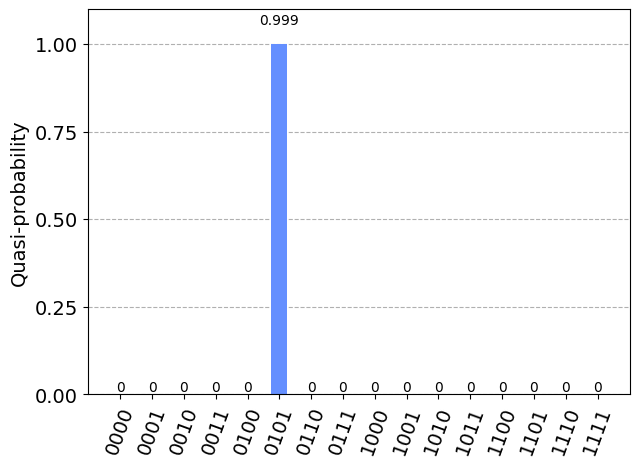

In [12]:
plot_histogram(QAOA_objective.set_circuit(theta=theta_f).get_state_probabilities(reverse_states=True))
